In [1]:
%cd /Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK
#!pwd
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts
import sys

testingscripts.realtimeFFT_validator() # Should return True

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK


True

# Real time S-D equations 
\begin{align}
G_+^{\mathrm{ret}}(\omega) &= \frac{1}{\omega-\mu-\Sigma_+^{\mathrm{ret}}(\omega)} \\
\Sigma_+^{\mathrm{ret}}(\omega) &= -2i J^2 \int_0^\infty dt\left[\Re{(n_{LL}^3)} - i\Im{(n_{LR}^3)}\right] e^{i\omega t} \\
n_{LL/LR}(t) &= \frac{1}{\pi}\int_{-\infty}^\infty d\omega \frac{\rho_+(\omega) \pm \rho_+(-\omega)}{2} n_F(\omega) e^{-i\omega t} \\
\rho_+(\omega) &= -\Im{G_+^{\mathrm{ret}}(\omega)}
\end{align}

#### Hindsight: no sign of revival oscillations :(

In [2]:
def rhotosigma(rhoG,M,dt,t,J,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    nLL = (0.5/np.pi)*freq2time((rhoG + rhoGrev) * fermidirac(beta*omega),M,dt)
    nLR = (0.5/np.pi)*freq2time((rhoG - rhoGrev) * fermidirac(beta*omega),M,dt)

    
    argSigma = (np.real(nLL**3) - 1j*np.imag(nLR**3)) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1.0)
    Sigma = -2j * (J**2) * time2freq(argSigma,M,dt)

    return Sigma

In [3]:
J = 0.5
mu = 0.001
#mu = 0

eta = 1e-6
beta = 1000.

M = int(2**18) #number of points in the grid
T = int(2**12) #upper cut-off fot the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-3

#delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

print("T = ", T, ", dw =  ", f'{dw:.6f}', ", dt = ", f'{dt:.6f}', ', omega_max = ', f'{omega[-1]:.3f}' ) 

T =  4096 , dw =   0.000767 , dt =  0.015625 , omega_max =  201.061


In [4]:
GRomega = (-1j)*np.ones(2*M)

#GRomega = 1/(omega + 1j*eta - mu)


itern = 0


diff = 1. 
diffG = 1.
xG = 0.5

while (diff>err and itern<200): 
    itern += 1 
    diffoldG = diffG
    GRoldomega= 1.0*GRomega
    
    rhoG = -1.0*np.imag(GRomega)
    
    SigmaOmega = rhotosigma(rhoG,M,dt,t,J,delta=1e-6)
    
    GRomega = 1.0*xG/(omega + 1j*eta - mu - SigmaOmega) + (1-xG)*GRoldomega
    
    diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) 
    diff = diffG
    
    if diffG>diffoldG:
        xG/=2.

    print("itern = ",itern, " , diff = ", diffG, " , x = ", xG, end = '\r')
        


/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))


In [5]:
GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)

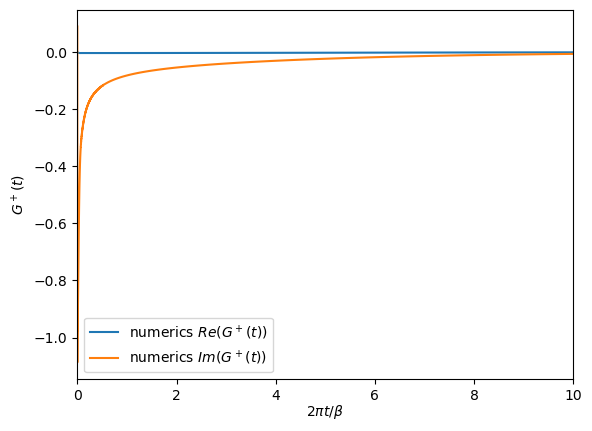

In [6]:
fig, ax = plt.subplots(1)

ax.plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics $Re(G^+(t))$')
ax.plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics $Im(G^+(t))$')
#ax.plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax.set_ylim(-1,1)
ax.set_xlim(0,10)
ax.set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax.set_ylabel(r'${G^+(t)}$')
ax.legend()



In [7]:
rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
rhoLL, rhoLR = 0.5 * (rhoG + rhoGrev), 0.5 * (rhoG - rhoGrev)
GLLomega = -1j*(1.-fermidirac(beta*omega))*rhoLL
GLRomega = -1j*(1.-fermidirac(beta*omega))*rhoLR
TLLt = 2 * np.abs((0.5/np.pi)*freq2time(GLLomega,M,dt)) 
TLRt = 2 * np.abs((0.5/np.pi)*freq2time(GLRomega,M,dt)) 

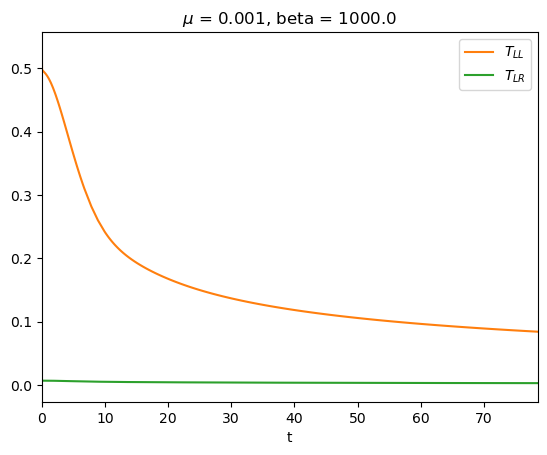

In [8]:
fig, ax = plt.subplots(1)
ax.plot(t, TLLt, c = 'C1', label = r'$T_{LL}$')
ax.plot(t, TLRt, c = 'C2', label = r'$T_{LR}$')
ax.set_xlim(0,25*np.pi)
ax.set_xlabel('t')
ax.set_title(f'$\mu$ = {mu}, beta = {beta}')
ax.legend()

In [9]:
M/T, dw, dt, omega[-1], 2**11

(64.0, 0.0007669903939428206, 0.015625, 201.06116283935282, 2048)

## Check low frequency power law

slope of fit = -0.483


/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_83646/167226625.py:7: RuntimeWarning: divide by zero encountered in power
  conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)


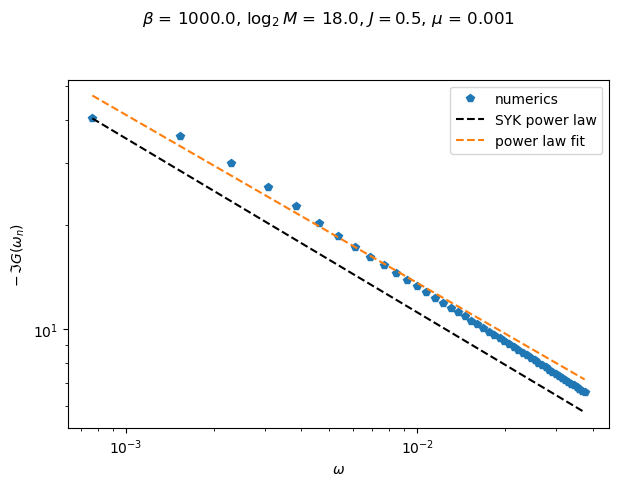

In [10]:
delta = 0.25
start,stop = M+1, M+50

functoplot = GLLomega

fitG_val = np.abs(functoplot[start])
conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val

fitslice = slice(start, start + 15)
m,c = np.polyfit(np.log(omega[fitslice]), np.log(np.abs(functoplot[fitslice])),1)
print(f'slope of fit = {m:.03f}')

fig, ax1 = plt.subplots(1)
#fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $J = $' + str(J) + r', $\mu$ = ' + str(mu)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:stop], np.abs(functoplot[start:stop]),'p',label = 'numerics')
ax1.loglog(omega[start:stop], conf_fit_G[start:stop],'k--',label = 'SYK power law')
ax1.loglog(omega[start:stop], np.exp(c)*(omega[start:stop])**m, '--', label = 'power law fit')



#ax1.set_xlim(omega[start]/2,omega[start+15])
#ax1.set_ylim(1e-1,1e1)
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega_n)}$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend()



In [11]:
sys.getsizeof(GRomega) / 10**9
#sys.getsizeof(1.6 + 2.2j) 

0.00838872